# Simulating a Multilevel Model
In the previous part of this lesson, we explored the multilevel framework from a purely theoretical and formal perspective. However, it can be tricky to wrap your head around all this, especially when you are not used to think in terms of multiple levels of variation. To try and help with this, we will explore *simulating* a multilevel model in `R`. This will serve two purposes. Firstly, it can be useful to see some code when trying to understand an abstract representation of a model. Secondly, there are some not-so-obvious consequences of the multilevel framework that make it particularly suited for repeated measurements. Although we could just state these consequences, the hope is that they are more concrete when actually seen as an emergent property of the multilevel framework.

## Simulation Code
The code for the simulations is given below. This is a direct implementation of the multilevel model visualised back in {numref}`multilevel-fig`, though we are now using $t = 3$ to show how the framework generalises to any number of repeated measures. You can spend time studying it and making the connections with the mathematical notation if you wish. However, the more important aspect is examining the *output*, so try not to get too side-tracked here.

In [1]:
set.seed(666)

#================================================================#
# Setup
#================================================================#

# simulation size
n.subs <- 10000                     # big N
n.t    <- 3                         # 3 repeated measures

# fixed-effects
mu    <- 5                          # group-level grand mean
alpha <- c(-2,1,3)                  # repeated measures effects

# variances
sigma2.1 <- 2                       # Level 1 (within-subject)
sigma2.2 <- 3                       # Level 2 (between-subjects)

# empty matrix for y (N x T)
y <- matrix(nrow=n.subs, ncol=n.t)

#================================================================#
# Run the simulations
#================================================================#

#----------------------------------------------------------------#
# Level 2 
#----------------------------------------------------------------#
# mu[i] ~ N(mu,sigma2.2)
#----------------------------------------------------------------#

mu.i <- rnorm(n.subs, mean=mu, sd=sqrt(sigma2.2))

#----------------------------------------------------------------#
# Level 1 
#----------------------------------------------------------------#
# y[ij] ~ N(mu[i] + alpha[j], sigma2.1)
#----------------------------------------------------------------#

for (i in 1:n.subs){
  for (j in 1:n.t){
    y[i,j] <- rnorm(n=1, mean=mu.i[i] + alpha[j], sd=sqrt(sigma2.1))
  }
}

In terms of running the code above, the main outputs are the subject means `mu.i`

In [2]:
head(mu.i)

[1] 6.304773 8.488965 4.384889 8.512890 1.160261 6.313581

and repeated measurement data itself `y`

In [3]:
head(y)

          [,1]     [,2]      [,3]
[1,]  4.888774 6.123403 10.577235
[2,]  6.363783 8.602728 11.434999
[3,]  3.351801 8.032131  8.484494
[4,]  7.631690 7.439201 12.534746
[5,] -2.930792 2.173460  4.901289
[6,]  4.878890 8.034805  9.735553

where each *row* is a subject and each *column* is one of the repeated measurement conditions. For simplicity, we will continue to refer to this condition as `time`, but it could of course be anything. Of importance is that we only have *one* measurement per-subject and per-repeat, so there are no replications here. We can see this in the Level 1 code `y[i,j] <- rnorm(n=1, ...)`. This is partly a *practical* decision to not complicate the indexing, but it does have some ramifications for visualising the model, as we will see below. 

## Level 2 Distribution

To begin with, let us have a look at the simulated distribution of subject means. This is the Level 2 distribution, illustrated back in {numref}`multilevel-fig`.

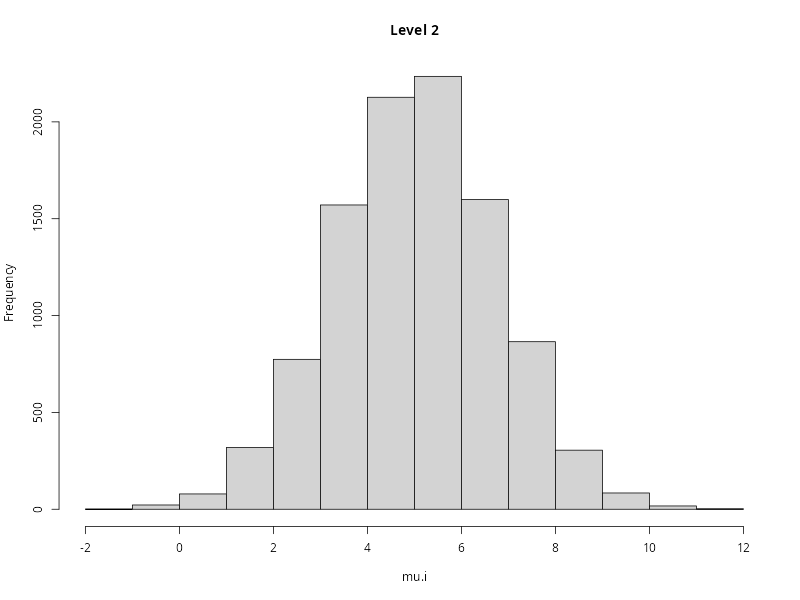

In [4]:
hist(mu.i, main='Level 2')

This represents our *population* of subjects. Each values on the $x$-axis represents an average value of our outcome variable for each subject. If we take one value from this distribution, we are sampling a *single* subject as a whole. The *width* of this distribution therefore represents variation *between* the subjects. It tells us how much we expect the subjects to differ from each other on average. In the simulations, we set $\sigma^{2}_{2} = 3$ and indeed we find that

In [5]:
var(mu.i)

[1] 2.998582

which is basically 3. Importantly, the elements of this distribution are taken as *independent* because each subject is assumed not to influence the response given by any other subject. This is implicit in the simulations because the vector of subject means are created as *independent* random draws from a normal distribution. In reality, this is an *assumption*, though usually a fairly reasonable one. 

## Level 1 Conditional Distributions
Next, let us focus on the Level 1 simulations. Remember that, for this example, we only simulated *one value* per-subject and per-repeated measurement. Because of this, we have no way of *seeing* the Level 1 distributions from {numref}`multilevel-fig`. Remember, these distributions are *subject-specific*. Every subject at every level of `time` has a distribution with a *unique* mean value. Formally, these are known as *conditional* distributions because they depend upon a specific subject. We would write

$$
y_{ij} | \mu_{i} \sim \mathcal{N}(\mu_{i} + \alpha_{j}, \sigma^{2}_{1}),
$$

which expresses the idea that this is the distribution of $y_{ij}$, but *only* for subject $i$ with a mean of $\mu_{i}$. Unfortunately, for these simulations, all we have is a *single* value from each one of these distributions. So we could *try* and plot them, but histograms drawn using a single datapoint do not tend to be particularly useful.

So, what we can do instead is run some additional simulations on specific subjects to generate enough values for visualisation. In the code below, we choose some random subject indices and then, for each of these subject, simulate 5,000 values from their distribution for each time-point. The results of doing this are then shown in the plots below. The three example subjects are given in the columns, with the distributions for time-point shown in rows. These are now examples of the conditional Level 1 distributions from {numref}`multilevel-fig`.

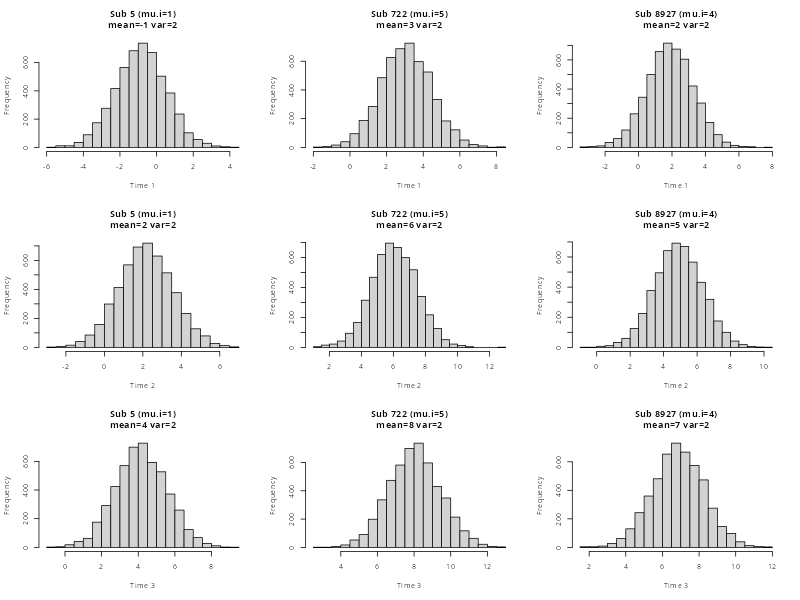

In [6]:
subs <- c(5,722,8927) # random subject numbers
n    <- length(subs)  # number of subjects

par(mfrow=c(3,n))

# plot each distribution
for (j in 1:3){
  for (i in 1:n){

    # subject index
    sub.idx  <- subs[i]

    # Level 1 distribution (n=5000 now rather than n=1)
    sub.dist <- rnorm(n=5000, mean=mu.i[sub.idx] + alpha[j], sd=sqrt(sigma2.1))
    
    # plot the distribution
    hist(sub.dist, 
         main=paste0('Sub ', sub.idx, ' (mu.i=', round(mu.i[sub.idx]), ')\nmean=', round(mean(sub.dist)), ' var=', round(var(sub.dist)) ),
         xlab=paste0('Time ', j), breaks=20)
  }
}

Notice that each one of these distributions has a *different mean* (indicated by `mean=` in the histogram titles). Even if they are from the *same subject* or from the *same time-point*. This is the essence of *conditional* distributions, because the mean depends upon *both* the time-point and the subject in question. For any one of the subjects and time-points, the distribution is given by

$$
y_{ij} | \mu_{i} \sim \mathcal{N}(\mu_{i} + \alpha_{j}, \sigma^{2}_{1}),
$$

so the *variance* is always the same, but the *mean* is a combination of something specific to that subject $\left(\mu_{i}\right)$ and something *universal* across measurements from the same time-point $\left(\alpha_{j}\right)$. In the simulations, we set $\sigma^{2}_{1} = 2$ and that is indeed what we see above (indicated by `var=` in the histogram titles). So this is the meaning of the *within-subject* variance, capturing the variability in measurements from *within a single subject*.   

In terms of the means, notice that each distribution for `Time 1` has a mean that is always 2 below the mean of the subject. So, Subject 5 has `mu.i=1` and their average response in Time 1 is $1 - 2 = -1$. Similarly, Subject 722 has `mu.i=5` and their average response in Time 1 is $5 - 2 = 3$. This is not a surprise, because in the simulations we set `alpha[1] <- -2`. So, no matter the subject, the average effect of `Time 1` is always the same. What changes is the individual subject's mean. This dictates the *scaling* of the measurements for that subject. Some people will just have lower values in general, whereas some people will just have higher values in general. We imagine that, on average, `time` affects every person in the same way, they just all start in a different place.

## The Marginal Distribution of the Data
Finally, let us have a look at the actual data that has been simulated *across* all the subjects. Here, we are not focussing on any single subject. Instead we have *collapsed* over all subjects. Formally, this is referred to as the *marginal* distribution, because we are looking at values averaged across all the subjects[^marginal-foot]. In general, the multilevel model works by decomposing the marginal distribution into a conditional distribution (Level 1) and a population distribution (Level 2). As such, the marginal distribution of the data is a combination of *both* Level 1 and Level 2. We can examine the results of the simulations to see how this has happened.

To begin with, we can plot the marginal distributions of each time-point from the simulations. Remember, these show the values of *all* subjects within each of the time-points. This is effectively the data for each *cell* of the design.

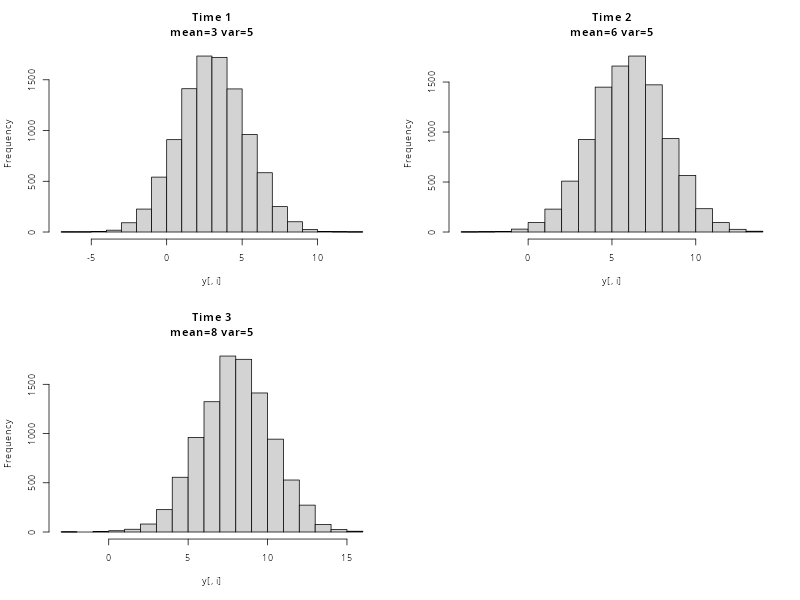

In [7]:
par(mfrow=c(2,2))
for (i in 1:3){
  hist(y[,i], main=paste0('Time ',i,'\nmean=',round(mean(y[,i])),' var=',round(var(y[,i]))))
}

In [8]:
par(mfrow=c(1,1))

To understand what these distributions are telling us about the multilevel model, we will focus on `Time 1`, which is shown in isolation below. 

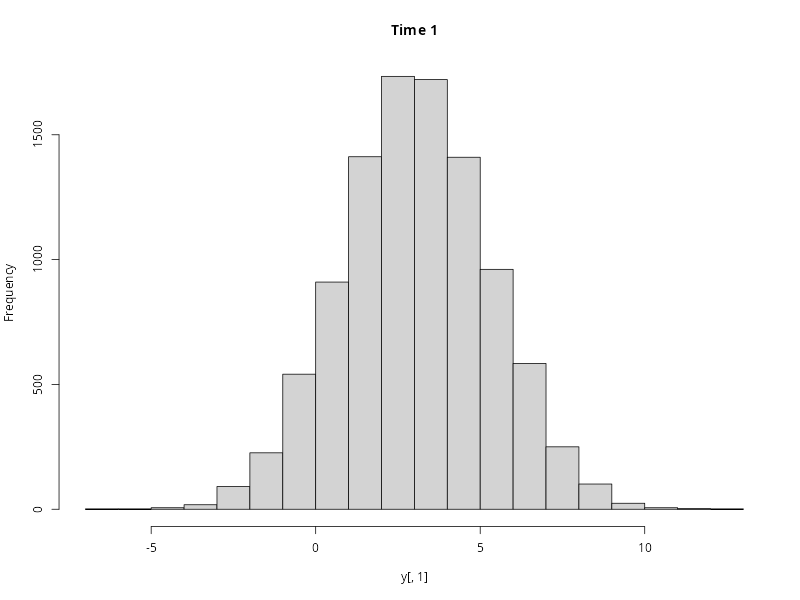

In [9]:
hist(y[,1], main='Time 1')

### The Marginal Mean
We will start by understanding the *mean* of this distribution. This is given by

In [10]:
mean(y[,1])

[1] 3.051084

Where does this value come from? Well, the *conditional* mean for `Time 1` is given by

$$
E(y_{i1}|\mu_{i}) = \mu_{i} + \alpha_{1},
$$

so this will jump around from subject-to-subject because the value of $\mu_{i}$ will keep changing. However, if we collapse across subjects, we get

$$
E(y_{i1}) = E(\mu_{i}) + \alpha_{1} = \mu + \alpha_{1}.
$$

Why? Because on average we expect the subject means to be equal to $\mu$. Why? Because our model says 

$$
\mu_{i} \sim \mathcal{N}\left(\mu,\sigma^{2}_{2}\right).
$$

So $E(\mu_{i}) = \mu$, which is the mean of the Level 2 distribution. Each subject mean is a draw from this distribution and so, on average, these should be equal to $\mu$. If we average-over all the subjects, we expect the average value of $\mu_{i}$ to be $\mu$. Because of this, the average value for data from time-point 1 should be $\mu + \alpha_{1}$. This is the grand mean of all the subjects plus the fixed-effect of `Time 1`. 

In the simulations, we set $\mu = 5$ and $\alpha_{1} = -2$. So, on average, a subject from this population will have a mean of 5, which will reduce by 2 during `Time 1`. So, our distribution for `Time 1` therefore a mean of $5 + (-2) = 3$, which is exactly what we see. This is also true of the other time-points. We set $\alpha_{2} = 1$ and so our expectation across subjects is that the distribution of `Time 2` will have a mean of $5 + 1 = 6$, which is what we see. Similarly, we set $\alpha_{3} = 3$ and so our expectation across subjects is that the distribution of `Time 3` will have a mean of $5 + 3 = 8$, which is again what we see. Importantly, these values are all products of *both levels* of the data-generating process. This demonstrates how the data are formed from Level 1 *and* Level 2 combined.

### The Marginal Variance
What about the *variance* of the marginal distribution? Again, we can calculate this from the simulations

In [11]:
var(y[,1])

[1] 5.007147

Where does this value come from? Well, the *conditional* variance for `Time 1` is given by

$$
\begin{alignat*}{2}
    \text{Var}(y_{i1}|\mu_{i}) &= \text{Var}(\mu_{i} + \alpha_{1} + \eta_{i1}) \\
                               &= \text{Var}(\eta_{i1}) \\
                               &= \sigma^{2}_{1} 
\end{alignat*}
$$

because our model says $\eta_{i1} \sim \mathcal{N}\left(0,\sigma^{2}_{1}\right)$. Why do both $\mu_{i}$ and $\alpha_{1}$ disappear? Well, $\alpha_{1}$ is a *population constant* and so its value never changes. As such, it is *not* a random variable and therefore has *0 variance*. In terms of $\mu_{i}$, that *is* a random variable. However, when we calculate the *conditional* distribution, we are doing that based on *one* specific subject. This means we *fix* $\mu_{i}$ to a specific value and it no longer acts like a random variable. As such, *conditionally* $\mu_{i}$ does not vary and thus also has *0 variance*. We saw this already because the conditional distributions for the example subjects above were based on fixing the value of `mu.i` to one specific value. When we did that, their variance was exactly $\sigma^{2}_{1}$.

Now, what happens when we collapse across subjects? Well, at that point we are not longer fixing the value of $\mu_{i}$. Thus, it still behaves like a *random variable* and thus contributes its variance to the data. This means that $\alpha_{1}$ will still drop-out, but *$\mu_{i}$ will not*. This results in

$$
\begin{alignat*}{2}
    \text{Var}(y_{i1}) &= \text{Var}(\mu_{i} + \alpha_{1} + \eta_{i1}) \\
                       &= \text{Var}(\mu_{i}) + \text{Var}(\eta_{i1}) \\
                       &= \text{Var}(\xi_{i}) + \text{Var}(\eta_{i1}) \\
                       &= \sigma^{2}_{1} + \sigma^{2}_{2} 
\end{alignat*}
$$

So, the variance of the marginal distribution is $\sigma^{2}_{1} + \sigma^{2}_{2}$. This means that *both* levels of the data are contributing to the variance we see in our data. This is *exactly* what we see in the simulations. There we set $\sigma^{2}_{1} = 2$ and $\sigma^{2}_{2} = 3$. So we expect that variance of the data will be $\sigma^{2}_{1} + \sigma^{2}_{2} = 2 + 3 = 5$. Which is *exactly* what we saw above. 

More generally, if we think of these as the *within-subject* variance $\left(\sigma^{2}_{w}\right)$ and the *between-subjects* variance $\left(\sigma^{2}_{b}\right)$ then the variance of our data is a *combination* of both these sources. So, $\text{Var}\left(y_{ij}\right) = \sigma^{2}_{w} + \sigma^{2}_{b}$. The multilevel model simply decomposes *where* these variance come from. The *within-subject* variation comes from the conditional distribution of each subject (Level 1), whereas the *between-subjects* comes from the population distribution (Level 2). So, both the *mean* and the *variance* of our measured data are *combinations* of both levels. This framework therefore allows us to understand complex data by modelling its structure layer-by-layer. Each layer can be very simple, but combined they can capture quite complex patterns in the data.

### The Marginal Covariance Structure
Now, for the party trick. During this section of the unit we have spend a lot of time thinking of the covariance structure of the data, yet this has been suspiciously absent so far in this lesson. Now we can start to join-the-dots. To see how, let us calculate and visualise the variance-covariance matrix of the simulated repeated measurements.

         [,1]     [,2]     [,3]
[1,] 5.007147 3.024842 3.016017
[2,] 3.024842 5.001325 2.958006
[3,] 3.016017 2.958006 5.002542


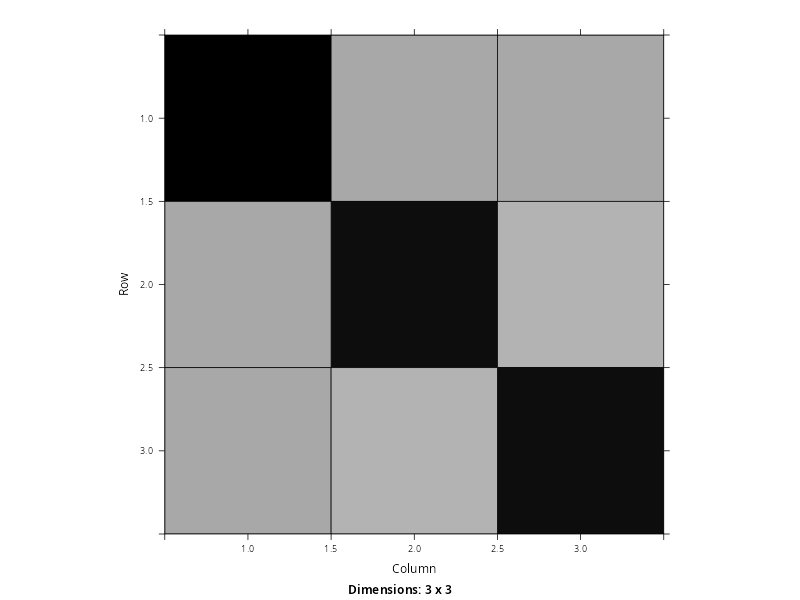

In [15]:
library(Matrix)
Sigma <- var(y)
print(Sigma)
image(as(Sigma,'Matrix'))

Notice anything familiar here? For starters, the simulated values of `time` are *correlated*. Now, this is not necessarily surprising, given that these are repeated measurements. *However*, consider for a moment the fact that *we did not simulate any correlation*. There is no multivariate normal distribution with a given covariance structure *anywhere* in the simulation code. In fact, no value for any correlation was specified. So where did this come from? 

This covariance is, in fact, a *natural consequence* of how a multilevel model is constructed. We do not need to specify correlation because it happens *automatically* as part of the connection between the levels of the model. This feels a bit like a magic trick, but is one of the big advantages of a multilevel model. We do not need to explicitly model dependence like we did with GLS. Instead, if we specify the structure of the model in terms of its layers, the covariance structure is taken into account *automatically*. Instead of thinking in terms of covariance structures, we can instead think about data structures. So long as we get the structure right, the correlation will be there as an emergent property of the model. In fact, we do not even need to think about correlation. This is particularly advantageous when we have complex data with more than two levels of variation. So long as we model the levels correctly, a complex covariance structure can simply fall-out of the model automatically.

The other familiar element here is that this structure is *compound symmetric*. So the covariance structure that emerges from this model is one of *identical* variances and *identical* covariances. 

- Multilevel structure creates correlation naturally, without specifying any form of variance-covariance matrix
- Diagonal elements are $\sigma^{2}_{1} + \sigma^{2}_{2} = 2 + 3 = 5$
- Off-diagonal elements are $\sigma^{2}_{1} = 2$
- This structure implies a compound-symmetric covariance matrix

[^marginal-foot]: The origin of this term is the same as *marginal means* in ANOVA tables. We are effectively *collapsing* over a specific dimension which, traditionally, would be performed by writing totals in the *margins* of a table.